# Exercitiul 1


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
from pandas import DataFrame

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
def standardize_data(X, mean = None, std = None):
    x_mean, x_std = mean, std
    if mean is None:
        x_mean = X.mean()
    if std is None:
        x_std = X.std()
    x_s = (X - x_mean) / x_std
    return x_s, x_mean, x_std

In [2]:
df = pd.read_csv('date_alegeri_turul2.csv')
df.head()

,Varsta,Sex,Educatie,Venit,Vot
0,45,1,0,8.06,1
1,39,1,1,6.48,1
2,46,1,1,5.48,1
3,55,0,0,5.61,1
4,38,1,1,5.86,1


In [44]:
cols = df.columns[:4]
x = []
for col in cols:
    x_curr = df[col].values.astype(float)
    x_s, x_mean, x_std = standardize_data(x_curr)
    x.append(x_s)
x = np.array(x).T

y = df['Vot'].values.astype(float)
x

array([[ 0.49898973,  1.040833  , -1.26240535,  0.94856835],
       [-0.11151973,  1.040833  , -0.00251977,  0.16833325],
       [ 0.60074131,  1.040833  , -0.00251977, -0.32548643],
       ...,
       [-0.2132713 , -0.96076892, -0.00251977, -0.00944183],
       [-0.92553234,  1.040833  ,  1.25736581,  0.35598473],
       [-1.43429022, -0.96076892,  1.25736581,  0.61770916]])

In [45]:
with pm.Model() as regression_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=len(cols))
    mu = alpha + pm.math.dot(x, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    yl = pm.Bernoulli('yl', p=theta, observed=y)
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [47]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.745,0.146,1.492,2.048,0.003,0.002,2906.0,2874.0,1.0
beta[0],0.293,0.129,0.059,0.537,0.002,0.001,4559.0,3279.0,1.0
beta[1],-0.427,0.125,-0.663,-0.197,0.002,0.001,4521.0,3119.0,1.0
beta[2],0.491,0.131,0.242,0.732,0.002,0.002,4216.0,3309.0,1.0
beta[3],1.014,0.140,0.749,1.276,0.003,0.002,3079.0,3519.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[495],0.981,0.007,0.968,0.992,0.000,0.000,2376.0,2599.0,1.0
theta[496],0.681,0.052,0.578,0.773,0.001,0.001,5306.0,3457.0,1.0
theta[497],0.888,0.020,0.848,0.924,0.000,0.000,3151.0,3219.0,1.0
theta[498],0.878,0.031,0.818,0.931,0.001,0.000,3681.0,3051.0,1.0


Observam ca urmatorii coeficienti au cea mai mare influenta, acestia fiind cei pentru Educatie si Venit

Cream acum un model cu acestia

In [48]:
with pm.Model() as regression_model_2:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    mu = alpha + pm.math.dot(x[:,2:], beta)
    
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha / beta[1] - beta[0] / beta[1] * x[:,2].flatten())
    
    yl = pm.Bernoulli('yl', p=theta, observed=y)
    
    trace_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


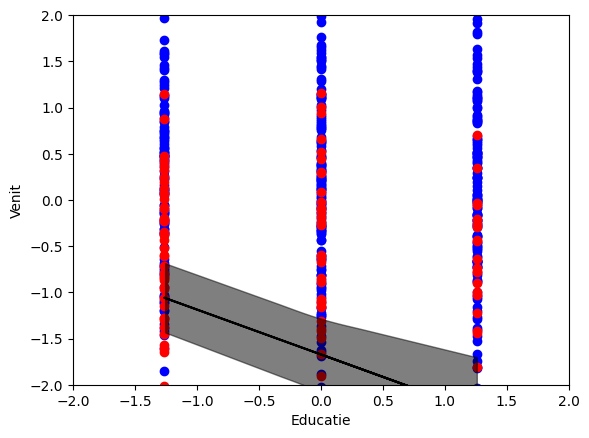

In [50]:
idx = np.argsort(y)
bd = trace_2.posterior['bd'].mean(("chain", "draw"))[idx]

plt.xlim(-2,2)
plt.ylim(-2,2)

plt.scatter(x[:,2][y == 1], x[:,3][y == 1], color='blue')
plt.scatter(x[:,2][y == 0], x[:,3][y == 0], color='red')

plt.plot(x[:,2][idx], bd, color='k')
az.plot_hdi(x[:,2], trace_2.posterior['bd'], color='k',hdi_prob=0.94)

plt.xlabel('Educatie')
plt.ylabel('Venit')

plt.show()

Verificarea modelelor folosind WAIC

Output()

Output()

                    rank   elpd_waic    p_waic  elpd_diff    weight  \
regression_model       0  423.438305  4.855582   0.000000  0.923607   
regression_model_2     1  436.755208  2.755019  13.316904  0.076393   

                           se       dse  warning     scale  
regression_model    24.972656  0.000000    False  deviance  
regression_model_2  25.015878  8.717431    False  deviance  


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

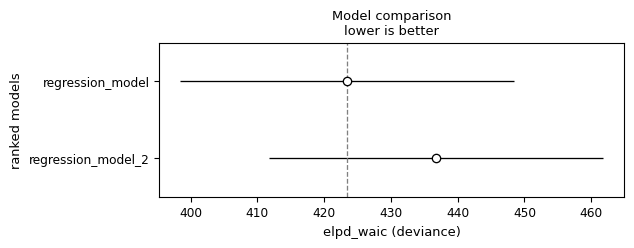

In [54]:
pm.compute_log_likelihood(trace,model=regression_model)
pm.compute_log_likelihood(trace_2,model=regression_model_2)
cmp_df = az.compare({'regression_model': trace, 'regression_model_2': trace_2},
                    method='BB-pseudo-BMA', ic="waic", scale="deviance")
print(cmp_df)
az.plot_compare(cmp_df)

See poate observa ca modelul cu toti parametrii este mai bun decat modelul cu doar 2 parametrii